# Scribe 6: Information Bottleneck Principle with Gaussian Processes

version: 5 December 3:20 AM

Our journey with Gaussian Processes till now:
- Scribe 4: Intoduction to Gaussian processes, The role of kernel parameters in ensuring effective compression and prrediction, predictive entropy
- Scribe 5: Knowledge Distillation of a Gaussian Process into a small neural network. How uncertainty weighted learning allows the student to not learn teacher's uncertain predictions.
- Scribe 6 [now..] : Information Bottleneck Analysis of the Knowledge Distillation Of a GP into a Neural Network

**Problem Statement:** Given input X and output Y, how do we find the optimal compressed representation Z that:
- Minimizes information about X: I(X; Z) → small (compression)
- Maximizes information about Y: I(Z; Y) → large (predictive power)

**The IB Objective:**
```
min L = I(X; Z) - β·I(Z; Y)
```

## Our Approach
- **Teacher:** Gaussian Process (rich information)
- **Students:** Neural networks with variable bottleneck dimensions (finite capacity)
- **Goal:** Visualize how bottleneck size controls the compression-accuracy trade-off

**Key Question:** As we compress the GP's knowledge into smaller representations, what information is preserved and what is lost?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from scipy.stats import entropy
import torch
import torch.nn as nn
import torch.optim as optim

from ipywidgets import interact
import ipywidgets as widgets

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 10

## 1. Generate Data and Train GP Teacher

Create a 1D regression problem and train a Gaussian Process.

GP trained on 20 points
Trained kernel: 0.921**2 * RBF(length_scale=0.149) + WhiteKernel(noise_level=0.0076)


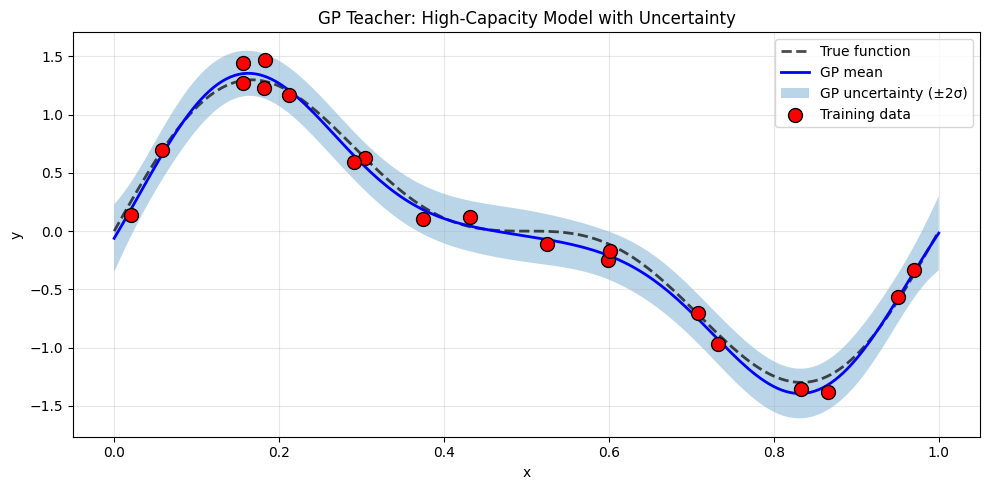


GP Test MSE: 0.003261


In [2]:
def true_function(x):
    """Ground truth function"""
    return np.sin(2 * np.pi * x) + 0.5 * np.sin(4 * np.pi * x)

# Training data (sparse)
n_train = 20
X_train = np.random.uniform(0, 1, n_train).reshape(-1, 1)
y_train = true_function(X_train).ravel() + np.random.normal(0, 0.1, n_train)

# Test data (dense)
X_test = np.linspace(0, 1, 200).reshape(-1, 1)
y_test = true_function(X_test).ravel()

# Distillation data (where we'll query the GP)
X_distill = np.linspace(0, 1, 500).reshape(-1, 1)

# Train GP
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1e1)) + WhiteKernel(noise_level=0.1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_train, y_train)

y_gp_distill, sigma_gp_distill = gp.predict(X_distill, return_std=True)
y_gp_test, sigma_gp_test = gp.predict(X_test, return_std=True)

print(f"GP trained on {n_train} points")
print(f"Trained kernel: {gp.kernel_}")

# Visualize
plt.figure(figsize=(10, 5))
plt.plot(X_test, y_test, 'k--', label='True function', linewidth=2, alpha=0.7)
plt.plot(X_test, y_gp_test, 'b-', label='GP mean', linewidth=2)
plt.fill_between(X_test.ravel(), 
                 y_gp_test - 2*sigma_gp_test,
                 y_gp_test + 2*sigma_gp_test,
                 alpha=0.3, label='GP uncertainty (±2σ)')
plt.scatter(X_train, y_train, c='red', s=100, marker='o', edgecolors='black', zorder=5, label='Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('GP Teacher: High-Capacity Model with Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

gp_mse = np.mean((y_gp_test - y_test)**2)
print(f"\nGP Test MSE: {gp_mse:.6f}")

## 2. Mutual Information Estimation

To measure I(X; Z) and I(Z; Y), we use binning-based MI estimation.

**MI Formula:** I(X; Y) = H(X) + H(Y) - H(X, Y)

In [3]:
# this was previously also done in scribe 4 (there we also discussed the gaussian approximation and kde methods)
def estimate_mi_binning(X, Y, bins=10):
    """
    Estimate mutual information I(X; Y) using binning.
    
    I(X; Y) = H(X) + H(Y) - H(X, Y)
    """
    # Ensure 2D arrays
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if Y.ndim == 1:
        Y = Y.reshape(-1, 1)
    
    # Discretize X and Y
    X_binned = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[1]):
        _, bin_edges = np.histogram(X[:, i], bins=bins)
        X_binned += np.digitize(X[:, i], bin_edges[:-1]) * (bins ** i)
    
    Y_binned = np.zeros(Y.shape[0], dtype=int)
    for i in range(Y.shape[1]):
        _, bin_edges = np.histogram(Y[:, i], bins=bins)
        Y_binned += np.digitize(Y[:, i], bin_edges[:-1]) * (bins ** i)
    
    # Compute histograms
    p_x = np.histogram(X_binned, bins=len(np.unique(X_binned)))[0] / len(X_binned)
    p_y = np.histogram(Y_binned, bins=len(np.unique(Y_binned)))[0] / len(Y_binned)
    p_xy = np.histogram2d(X_binned, Y_binned, bins=[len(np.unique(X_binned)), len(np.unique(Y_binned))])[0] / len(X_binned)
    
    # Remove zeros
    p_x = p_x[p_x > 0]
    p_y = p_y[p_y > 0]
    p_xy = p_xy[p_xy > 0]
    
    # Compute entropies
    H_X = entropy(p_x, base=2)
    H_Y = entropy(p_y, base=2)
    H_XY = entropy(p_xy.ravel(), base=2)
    
    # MI = H(X) + H(Y) - H(X,Y)
    mi = H_X + H_Y - H_XY
    
    return max(0, mi)  # MI is non-negative

# Test MI estimation
print("Testing MI estimation...")
test_X = np.random.randn(1000, 2)
test_Y = (test_X[:, 0] + test_X[:, 1] > 0).astype(float)
mi_test = estimate_mi_binning(test_X, test_Y.reshape(-1, 1))
print(f"I(X; Y) for correlated data: {mi_test:.3f} bits")

test_Y_rand = np.random.randn(1000)
mi_test_rand = estimate_mi_binning(test_X, test_Y_rand.reshape(-1, 1))
print(f"I(X; Y) for random data: {mi_test_rand:.3f} bits (should be ~0)")

Testing MI estimation...
I(X; Y) for correlated data: 0.814 bits
I(X; Y) for random data: 0.267 bits (should be ~0)


## 3. Define Student Network with Bottleneck

Simple encoder-predictor architecture:
- **Encoder:** X → Z (bottleneck)
- **Predictor:** Z → Y

In [4]:
class StudentNetwork(nn.Module):
    def __init__(self, input_dim=1, bottleneck_dim=2, hidden_dim=32):
        super(StudentNetwork, self).__init__()
        
        # Encoder: X -> Z
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.Tanh()  # Bound the representation
        )
        
        # Predictor: Z -> Y
        self.predictor = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def predict(self, z):
        return self.predictor(z)
    
    def forward(self, x):
        z = self.encode(x)
        y_pred = self.predict(z)
        return z, y_pred

# Test
test_student = StudentNetwork(input_dim=1, bottleneck_dim=2, hidden_dim=32)
print("Student Network Architecture:")
print(f"  Encoder: 1 → 32 → 2 (bottleneck)")
print(f"  Predictor: 2 → 32 → 1")
print(f"  Total parameters: {sum(p.numel() for p in test_student.parameters())}")

Student Network Architecture:
  Encoder: 1 → 32 → 2 (bottleneck)
  Predictor: 2 → 32 → 1
  Total parameters: 259


## 4. Training Function

Train student to match GP's predictions on distillation data.

In [5]:
def train_student(model, X, y, weights=None, beta=1.0, epochs=1000, lr=0.01, verbose=False):
    """Train student network on GP's predictions."""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                     patience=100, verbose=False)
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1)
    
    if weights is not None and weights != 'ib_proxy':
        weights_tensor = torch.FloatTensor(weights).reshape(-1, 1)
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        z, y_pred = model(X_tensor)
        
        # Choose loss based on weight type
        if weights == 'ib_proxy':
            # IB proxy loss: compression + beta * prediction
            prediction_loss = nn.MSELoss()(y_pred, y_tensor)
            compression_loss = torch.mean(z**2)  # L2 penalty on representations
            loss = compression_loss + beta * prediction_loss 
            #Important Note: In the IB objective we have min(compress_mutual_info - beta*pred_mutual_info)
            #here since we are using proxies -- we have the obejctive min(compression_loss + beta * prediction_loss) 
            #we can do this because if pred_mutual_info is high -- prediction_loss would be low 

        elif weights is not None:
            # Uncertainty-weighted loss
            loss = torch.mean(weights_tensor * (y_pred - y_tensor)**2)
        else:
            # Uniform loss
            loss = nn.MSELoss()(y_pred, y_tensor)
        
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        losses.append(loss.item())
        
        if verbose and (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    
    return losses

def evaluate_student(model, X, y):
    """Evaluate student network."""
    model.eval()
    with torch.no_grad():
        z = model.encode(torch.FloatTensor(X)).numpy()
        y_pred = model(torch.FloatTensor(X))[1].numpy().ravel()
    model.train()
    
    mse = np.mean((y_pred - y)**2)
    return z, y_pred, mse

## 5 Experiment: Train Students with Different Bottleneck Sizes

Train students with bottleneck dimensions: [1, 2, 4, 8, 16]
- Smaller bottleneck → more compression → lower I(X; Z)
- Larger bottleneck → less compression → higher I(X; Z)

In [6]:
print("=== Training students with IB Proxy Loss (Different Betas) ===")

bottleneck_dims = [1, 2, 4, 8, 16]
betas_to_train = [0.1, 0.5, 1.0, 2.0, 5.0]

all_results = []

for dim in bottleneck_dims:
    print(f"\n--- Bottleneck dim = {dim} ---")
    
    # Train with different beta values
    for beta in betas_to_train:
        model = StudentNetwork(input_dim=1, bottleneck_dim=dim, hidden_dim=32)
        losses = train_student(model, X_distill, y_gp_distill, weights='ib_proxy', 
                              beta=beta, epochs=1500, lr=0.01, verbose=False)
        
        # Evaluate on training data (for MI computation)
        z_train, _, _ = evaluate_student(model, X_train, y_train)
        
        # Evaluate on test data (for MSE)
        z_test, y_pred_test, mse = evaluate_student(model, X_test, y_test)
        
        # Compute MI
        I_XZ = estimate_mi_binning(X_train, z_train, bins=8)
        I_ZY = estimate_mi_binning(z_train, y_train.reshape(-1, 1), bins=8)
        
        all_results.append({
            'dim': dim,
            'beta': beta,
            'model': model,
            'I_XZ': I_XZ,
            'I_ZY': I_ZY,
            'mse': mse,
            'z_train': z_train,
            'z_test': z_test,
            'y_pred_test': y_pred_test
        })
        
        print(f"  β={beta:4.1f} - MSE: {mse:.6f}, I(X;Z): {I_XZ:.3f}, I(Z;Y): {I_ZY:.3f}")

# Compute MI for GP teacher
gp_predictions_train = gp.predict(X_train).reshape(-1, 1)
I_XZ_gp = estimate_mi_binning(X_train, gp_predictions_train, bins=8)
I_ZY_gp = estimate_mi_binning(gp_predictions_train, y_train.reshape(-1, 1), bins=8)

print(f"\n--- GP Teacher ---")
print(f"Test MSE: {gp_mse:.6f}")
print(f"I(X; Z_GP) = {I_XZ_gp:.3f} bits")
print(f"I(Z_GP; Y) = {I_ZY_gp:.3f} bits")
print("\nTraining complete!")

=== Training students with IB Proxy Loss (Different Betas) ===

--- Bottleneck dim = 1 ---
  β= 0.1 - MSE: 0.017811, I(X;Z): 2.153, I(Z;Y): 2.390
  β= 0.5 - MSE: 0.016967, I(X;Z): 2.190, I(Z;Y): 2.528
  β= 1.0 - MSE: 0.017170, I(X;Z): 2.153, I(Z;Y): 2.528
  β= 2.0 - MSE: 0.004473, I(X;Z): 2.128, I(Z;Y): 2.466
  β= 5.0 - MSE: 0.003649, I(X;Z): 2.490, I(Z;Y): 2.390

--- Bottleneck dim = 2 ---
  β= 0.1 - MSE: 0.016842, I(X;Z): 2.253, I(Z;Y): 2.490
  β= 0.5 - MSE: 0.003701, I(X;Z): 2.228, I(Z;Y): 2.566
  β= 1.0 - MSE: 0.016870, I(X;Z): 2.253, I(Z;Y): 2.628
  β= 2.0 - MSE: 0.003365, I(X;Z): 2.353, I(Z;Y): 2.353
  β= 5.0 - MSE: 0.003461, I(X;Z): 2.148, I(Z;Y): 2.048

--- Bottleneck dim = 4 ---
  β= 0.1 - MSE: 0.003371, I(X;Z): 2.328, I(Z;Y): 2.428
  β= 0.5 - MSE: 0.016648, I(X;Z): 2.628, I(Z;Y): 2.728
  β= 1.0 - MSE: 0.004045, I(X;Z): 2.666, I(Z;Y): 2.428
  β= 2.0 - MSE: 0.004983, I(X;Z): 2.148, I(Z;Y): 2.348
  β= 5.0 - MSE: 0.003561, I(X;Z): 2.085, I(Z;Y): 1.985

--- Bottleneck dim = 8 ---


## 6. Visualize the Information Plane

Plot I(X; Z) vs. I(Z; Y) to see the Information Bottleneck trade-off.

In [12]:
def plot_analysis_for_beta(beta):
    """
    Analyze a specific beta value across all dimensions.
    """
    results_beta = [r for r in all_results if r['beta'] == beta]
    
    if len(results_beta) == 0:
        print(f"No results for beta={beta}")
        return
    
    plt.figure(figsize=(18, 5))
    
    dims = [r['dim'] for r in results_beta]
    I_XZ_vals = [r['I_XZ'] for r in results_beta]
    I_ZY_vals = [r['I_ZY'] for r in results_beta]
    mses = [r['mse'] for r in results_beta]
    
    # Plot 1: Information Plane for this beta
    plt.subplot(1, 3, 1)
    plt.plot(I_XZ_vals, I_ZY_vals, 'o-', markersize=10, linewidth=2, 
             label=f'β={beta}', color='purple')
    
    # Annotate with dimensions
    for i, dim in enumerate(dims):
        plt.annotate(f'd={dim}', (I_XZ_vals[i], I_ZY_vals[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.scatter(I_XZ_gp, I_ZY_gp, s=300, marker='*', c='red', edgecolors='black', 
               linewidths=2, zorder=10, label='GP Teacher')
    
    plt.xlabel('I(X; Z) - Complexity (bits)', fontsize=12)
    plt.ylabel('I(Z; Y) - Predictive Info (bits)', fontsize=12)
    plt.title(f'Information Plane (β={beta})', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Plot 2: MSE vs Dimension
    plt.subplot(1, 3, 2)
    plt.plot(dims, mses, 'o-', markersize=8, linewidth=2, color='blue')
    plt.axhline(y=gp_mse, color='red', linestyle='--', linewidth=2, label='GP Teacher')
    plt.xlabel('Bottleneck Dimension', fontsize=12)
    plt.ylabel('Test MSE', fontsize=12)
    plt.title(f'MSE vs. Dimension (β={beta})', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot 3: MI vs Dimension
    plt.subplot(1, 3, 3)
    plt.plot(dims, I_XZ_vals, 'o-', markersize=8, linewidth=2, label='I(X; Z)', color='blue')
    plt.plot(dims, I_ZY_vals, 's-', markersize=8, linewidth=2, label='I(Z; Y)', color='green')
    plt.axhline(y=I_XZ_gp, color='blue', linestyle='--', alpha=0.5)
    plt.axhline(y=I_ZY_gp, color='green', linestyle='--', alpha=0.5)
    plt.xlabel('Bottleneck Dimension', fontsize=12)
    plt.ylabel('Mutual Information (bits)', fontsize=12)
    plt.title(f'MI vs. Dimension (β={beta})', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("INTERACTIVE: Select beta to analyze")
print("High β (e.g., 5) Focuses on prediction → higher I(X;Z)")
print("Low β (e.g., 0.1): Focuses on compression → lower I(X;Z)")
print("Information plane shows beta controls the trade-off curve")
print("="*70)
print("For the left plot: \n We want to reduce the compression MI and increase the predictive MI. Points closer to the star are good. Ideally we would have wanted points that are high in Y axis and left in X axis")
print()
print("For the center plot: \n We want the MSE to be as close to the red dotted line or even below(!)")
print()
print("For the right plot: \n We want something that brings the green dot close to the green dotted line (or above it!) and the blue dot close to blue dotted line (or below it!)")

print("="*70)

interact(plot_analysis_for_beta, 
         beta=widgets.SelectionSlider(
             options=betas_to_train,
             value=1.0,
             description='Beta (β):',
             continuous_update=False,
         ))


INTERACTIVE: Select beta to analyze
High β (e.g., 5) Focuses on prediction → higher I(X;Z)
Low β (e.g., 0.1): Focuses on compression → lower I(X;Z)
Information plane shows beta controls the trade-off curve
For the left plot: 
 We want to reduce the compression MI and increase the predictive MI. Points closer to the star are good. Ideally we would have wanted points that are high in Y axis and left in X axis

For the center plot: 
 We want the MSE to be as close to the red dotted line or even below(!)

For the right plot: 
 We want something that brings the green dot close to the green dotted line (or above it!) and the blue dot close to blue dotted line (or below it!)


interactive(children=(SelectionSlider(continuous_update=False, description='Beta (β):', index=2, options=(0.1,…

<function __main__.plot_analysis_for_beta(beta)>

## 7. Visualize Student Predictions

Compare how students with different bottlenecks approximate the GP.

In [8]:
def plot_predictions_for_beta_and_dim(beta, dim):
    """
    Plot predictions for a specific beta and dimension.
    """
    results_match = [r for r in all_results if r['beta'] == beta and r['dim'] == dim]
    
    if len(results_match) == 0:
        print(f"No results for beta={beta}, dim={dim}")
        return
    
    result = results_match[0]
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Predictions
    plt.subplot(1, 2, 1)
    plt.plot(X_test, y_test, 'k--', label='True function', linewidth=2, alpha=0.5)
    plt.plot(X_test, y_gp_test, 'b-', label='GP teacher', linewidth=2, alpha=0.7)
    plt.fill_between(X_test.ravel(), 
                     y_gp_test - 2*sigma_gp_test,
                     y_gp_test + 2*sigma_gp_test,
                     alpha=0.2, color='blue')
    plt.plot(X_test, result['y_pred_test'], '-', color='purple', 
            label=f'IB Proxy (β={beta}, d={dim})', linewidth=2)
    plt.scatter(X_train, y_train, c='red', s=50, marker='o', edgecolors='black', zorder=5)
    
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title(f'Predictions: β={beta}, d={dim}\nMSE={result["mse"]:.4f}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Information metrics
    plt.subplot(1, 2, 2)
    
    metrics = ['I(X;Z)', 'I(Z;Y)', 'MSE×10']
    values = [result['I_XZ'], result['I_ZY'], result['mse']*10]  # Scale MSE for visibility
    colors_bar = ['blue', 'green', 'orange']
    
    bars = plt.bar(metrics, values, color=colors_bar, alpha=0.7, edgecolor='black')
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=11)
    
    plt.ylabel('Value', fontsize=12)
    plt.title(f'Metrics: β={beta}, d={dim}', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("INTERACTIVE: Select beta and dimension to see predictions")
print("="*70)

interact(plot_predictions_for_beta_and_dim, 
         beta=widgets.SelectionSlider(
             options=betas_to_train,
             value=1.0,
             description='Beta (β):',
             continuous_update=False,
         ),
         dim=widgets.Dropdown(
             options=bottleneck_dims,
             value=4,
             description='Dimension:',
         ))

# Print summary
print("\n" + "="*70)
print("KEY OBSERVATIONS:")
print("="*70)
print("1. Low β (e.g., 0.1): Focuses on compression → lower I(X;Z), higher MSE")
print("2. High β (e.g., 5.0): Focuses on prediction → higher I(X;Z), lower MSE")
print("="*70)


INTERACTIVE: Select beta and dimension to see predictions


interactive(children=(SelectionSlider(continuous_update=False, description='Beta (β):', index=2, options=(0.1,…


KEY OBSERVATIONS:
1. Low β (e.g., 0.1): Focuses on compression → lower I(X;Z), higher MSE
2. High β (e.g., 5.0): Focuses on prediction → higher I(X;Z), lower MSE


In [9]:
def print_summary_table(beta):
    """Print summary for a specific beta."""
    
    results_beta = [r for r in all_results if r['beta'] == beta]
    
    print("\n" + "="*70)
    print(f"SUMMARY TABLE: Beta = {beta}")
    print("="*70)
    print(f"{'Dim':<6} {'I(X;Z)':<10} {'I(Z;Y)':<10} {'Test MSE':<12}")
    print("-"*70)
    print(f"{'GP (∞)':<6} {I_XZ_gp:<10.3f} {I_ZY_gp:<10.3f} {gp_mse:<12.6f}")
    print("-"*70)
    
    for r in sorted(results_beta, key=lambda x: x['dim']):
        print(f"{r['dim']:<6} {r['I_XZ']:<10.3f} {r['I_ZY']:<10.3f} {r['mse']:<12.6f}")
    
    print("="*70)

interact(print_summary_table, 
         beta=widgets.SelectionSlider(
             options=betas_to_train,
             value=1.0,
             description='Beta (β):',
             continuous_update=False,
         ))

interactive(children=(SelectionSlider(continuous_update=False, description='Beta (β):', index=2, options=(0.1,…

<function __main__.print_summary_table(beta)>

Some Comments and Observations:

- **GP acts as High-Capacity Teacher:**
   - GP encodes rich information through its kernel and posterior
   - Students compress this into finite-dimensional representations
   - The kernel's length scale implicitly defines "relevant" information


- **The IB Trade-off -- For each beta**
   - Smaller bottleneck (d=1,2) → lower I(X; Z) → higher MSE → less predictive info I(Z; Y)
   - Larger bottleneck (d=16) → higher I(X; Z) → lower MSE → more predictive info I(Z; Y)
   - The GP sits at the "high capacity" end with maximum information


